<div style="background-color:lightgreen; border-style: double;border-color: #00beef;text-align:center;color:blue;font-size:25px;border-radius: 50px;padding: 20px 20px; font-family:Raleway;"><strong> Gashaw M. Goshu, Ph.D. in Chemistry</strong></div>

<div style= " border-style:double;text-align:left;color:blue;font-size:18px;border-radius: 10px;padding: 20px 20px;">
<h3> Implementing  Water Solubility Prediction Web App from Scratch </h3><br>
=================================================================================================
<div style= "text-align:left;color:darkgreen;font-size:16px;border-radius:10px;">
<h4> Part I:  </h4><br>
1.	Get Solubility Data and Clean the Data<br>
2.	Generate Molecular Descriptors or Features<br>
3.	Split Compounds for Training and Test set<br>
4.	Select Machine Learning Models (<b>42</b> ML models)<br>
5.	Fine-tune the Selected Model <br>
6.  Use the Optimal Model for Test data<br>
7.  Save the Trained Model and Standard Scaler for New Data<br>
</div></div>

<h3 style="color:blue">Brief Introduction</h3><br>
<b>Solubility</b> is defined as the maximum amount of solute that will dissolve in a given amount of solvent to form a saturated solution at a specified temperature, usually at room temperature.
<div>
    <table>
        <tr> <td><img src="solution.jpg"; width="700px"; align="left";alt="picture of saturated solution"></td>
             <td><img src="solubility.jpg"; width="300px"; align="left";alt="picture of saturated solution"></td>           
        <tr/>
    </table>
</div>
<br>Remember the principle <i style="color:red">"like dissolves like"</i>, which means that molecules with similar polarities and intermolecular forces are more likely to dissolve in each other.<br>
<b>Water solubility</b> is an important property in drug discovery because it affects <i style="color:red">bioavailability</i>, which is <i> the extent to which a drug can be absorbed and reach its target site </i>. Even we cannot perform a biological assay if a compound does not dissolve in water.<br>
This implies the molecular structure of a compound can significantly influence its solubility. Polar or ionizable groups, such as carboxylic acid or amine groups, can increase water solubility, while nonpolar groups, such as long hydrocarbon chains, can decrease solubility.
In this case, <b style="color:blue"> we will use the 200 RDKit molecular descriptors, <i>which are numerical representations of a molecular structure<i>, as input features to predict aqueous solubility.<br><br>
<div>
<img src="descriptors.jpg";width="500px";align="left">
</div>

In [1]:
### Import Relevant libraries
import warnings
warnings.filterwarnings("ignore")
#----------------------------------
import numpy as np
import pandas as pd
#----------------------------------
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sn
#----------------------------------
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
from lightgbm import LGBMRegressor
#----------------------------------
# helps to train 42 ML models with a single line of code
import lazypredict
from lazypredict.Supervised import LazyRegressor
from tqdm import tqdm
#----------------------------------
from rdkit.Chem import AllChem
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors

<div style= "background-color: lightcyan;text-align:left;color:blue;font-size:20px;border-radius: 10px;padding: 20px 20px;">
1. Get Solubility Data and Perform Exploratory Data Analysis (EDA)</div>


- SMILES strings and aqueous solubility in logS (mol/L) of compounds were taken from publication by [Cui, Qiuji, et al.](https://www.frontiersin.org/articles/10.3389/fonc.2020.00121/full).
-[Pat Walters - Blogpost](https://practicalcheminformatics.blogspot.com/2018/09/predicting-aqueous-solubility-its.html)  is an excellent blogpost for aqueous solubility.

In [2]:
# open a file containing descriptors and yield
data = pd.read_csv(r"D:\Aqueous solubility_9945.csv")

In [3]:
data.shape

(9956, 6)

In [4]:
data.head()

,Compound ID,InChIKey,SMILES,logS,logP,MW
0,C1711,ACTIUHUUMQJHFO-UPTCCGCDSA-N,COC1=C(OC)C(=O)C(=C(C1=O)C/C=C(/CC/C=C(/CC/C=C...,-18.22,17.85,863.34
1,C1712,CQISYTXUORWJSX-UHFFFAOYSA-N,CCCCCCCCCCCCCCCCCC(=O)Nc1ccc(cc1)NC(=O)CCCCCCC...,-17.47,14.23,641.07
2,C1713,UXPYIAWFQKSHNV-UHFFFAOYSA-N,CCCCCCCCCCCCCCCC(=O)OCCCCOC(=O)CCCCCCCCCCCCCCC,-16.26,11.82,566.94
3,C1714,BDIWFCKBPZPBQT-UHFFFAOYSA-N,CCCC[Sn](S[Sn](CCCC)(CCCC)CCCC)(CCCC)CCCC,-15.68,10.41,612.15
4,C1715,RNPXCFINMKSQPQ-UHFFFAOYSA-N,CCCCCCCCCCCCCCCCOP(=O)(OCCCCCCCCCCCCCCCC)O,-15.21,12.08,546.85


<div style= " text-align:left;color:red;font-size:25px;border-radius: 10px;padding: 20px 20px;">
1.1  Remove NaN or null values
</div>

In [5]:
# Calculate the number of null values for SMILES
data.SMILES.isnull().sum()

13

In [6]:
# remove NaN values
data.dropna(inplace=True)

In [7]:
data.shape

(9943, 6)

<div style= " text-align:left;color:red;font-size:25px;border-radius: 10px;padding: 20px 20px;">
1.2  Remove outliers
</div>

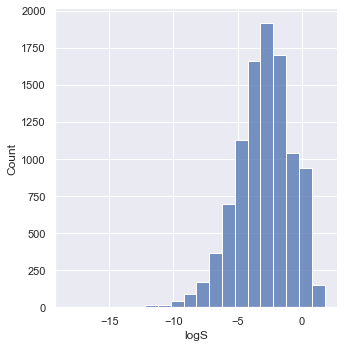

In [8]:
# Generate histogram
# left skewed or negative skew
sn.set_theme()
sn.displot(data=data, x="logS", binwidth=1)

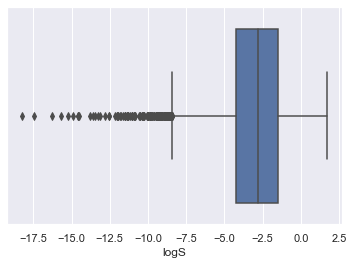

In [9]:
# Boxplot  
sn.boxplot(data=data, x='logS')

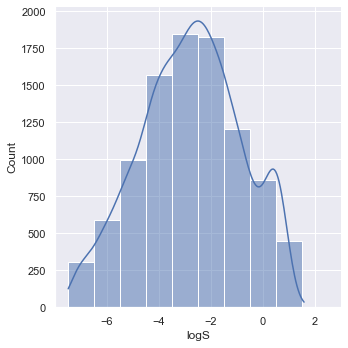

In [10]:
#### filter compounds that follow as close as normal distribution
data_new = data[data.logS.apply(lambda x: x > -7.5 and x < 1.7)]
# Generate histogram
sn.displot(data=data_new, x='logS', binwidth=1,kde=True)

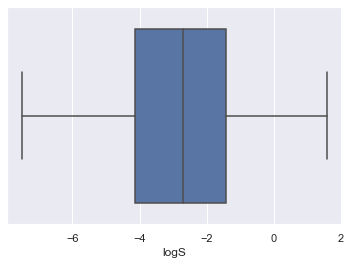

In [11]:
# Boxplot  
sn.boxplot(data=data_new, x='logS')

In [12]:
data_new.shape

(9648, 6)

<div style= " text-align:left;color:red;font-size:25px;border-radius: 10px;padding: 20px 20px;">
1.3 Remove duplicates if any
</div>

In [13]:
# generate canonical SMILES
def canonical_SMILES(smiles):
    canon_smi = [Chem.CanonSmiles(smi) for smi in smiles]
    return canon_smi

In [14]:
# Generate canonical Smiles
canon_smiles = canonical_SMILES(data_new.SMILES)

# Replace SMILES column wit Canonical SMILES
data_new["SMILES"] = canon_smiles

# Create a list for duplicate smiles
duplicate_smiles = data_new[data_new['SMILES'].duplicated()]['SMILES'].values
len(duplicate_smiles)

6

In [15]:
# filter the duplicate smiles and sort them based on smiles
data_new[data_new['SMILES'].isin(duplicate_smiles)].sort_values(by=['SMILES'])

,Compound ID,InChIKey,SMILES,logS,logP,MW
5683,C1698,WUBBRNOQWQTFEX-UHFFFAOYSA-N,CC(=O)Nc1nnc(S(N)(=O)=O)s1,-2.44,1.00,222.25
5836,C943,BZKPWHYZMXOIDC-UHFFFAOYSA-N,CC(=O)Nc1nnc(S(N)(=O)=O)s1,-2.36,1.00,222.25
7282,C7745,VWPOSFSPZNDTMJ-UCWKZMIHSA-N,CC(C)(C)NCC(O)COc1cccc2c1C[C@H](O)[C@H](O)C2,-1.57,1.03,309.40
8063,C1707,IWVCMVBTMGNXQD-PXOLEDIWSA-N,CC(C)(C)NCC(O)COc1cccc2c1C[C@H](O)[C@H](O)C2,-1.01,1.03,309.40
1345,C199,WKRLQDKEXYKHJB-HFTRVMKXSA-N,C[C@]12CC[C@H]3C(=CCc4cc(O)ccc43)[C@@H]1CCC2=O,-5.28,3.74,268.35
1347,C1673,WKRLQDKEXYKHJB-HFTRVMKXSA-N,C[C@]12CC[C@H]3C(=CCc4cc(O)ccc43)[C@@H]1CCC2=O,-5.28,3.74,268.35
5152,C1696,QZUDBNBUXVUHMW-UHFFFAOYSA-N,Cc1cc(NS(=O)(=O)c2ccc(N)cc2)no1,-2.70,3.10,253.28
5319,C843,JLKIGFTWXXRPMT-UHFFFAOYSA-N,Cc1cc(NS(=O)(=O)c2ccc(N)cc2)no1,-2.62,3.10,253.28
3918,C604,NXFQHRVNIOXGAQ-YCRREMRBSA-N,O=C1CN(/N=C/c2ccc([N+](=O)[O-])o2)C(=O)N1,-3.38,0.86,238.16
4159,C1690,NXFQHRVNIOXGAQ-OQFOIZHKSA-N,O=C1CN(/N=C/c2ccc([N+](=O)[O-])o2)C(=O)N1,-3.24,0.86,238.16


In [16]:
# Drop rows that contain duplicate SMILES and keep the first Structure
data_cleaned = data_new.drop_duplicates(subset=['SMILES'], keep='first')
len(data_cleaned)

9642

<div style= " text-align:left;color:red;font-size:25px;border-radius: 10px;padding: 20px 20px;">
1.4 Filter training data that does not contain test data. 
</div>

<div style= " text-align:left;color:green;font-size:18px;padding: 20px 20px;">
Test Set data contains <b>100 Drug-like Compounds:-</b> determined in one lab using accurate solubility experiment. Please read the following references 
</div>

[Reference for the publication](https://pubs.acs.org/doi/full/10.1021/mp500103r)

[Reference for the test set data](https://risweb.st-andrews.ac.uk/portal/en/datasets/dls100-solubility-dataset(3a3a5abc-8458-4924-8e6c-b804347605e8).html)


In [17]:
test_set = pd.read_csv(r"d:/Drug_Like_Solubility _100.csv")
test_set

,Chemical name,SMILES,LogS exp (mol/L)
0,Acetanilide,O=C(Nc1ccccc1)C,-1.40
1,Adenosine,c1nc(c2c(n1)n(cn2)[C@H]3[C@@H]([C@@H]([C@H](O3...,-1.73
2,Allopurinol,c1c2c([nH]n1)ncnc2O,-2.26
3,Trimethoprim,COc1cc(cc(c1OC)OC)Cc2cnc(nc2N)N,-2.95
4,Acetazolamide,O=S(=O)(c1nnc(s1)NC(=O)C)N,-2.44
...,...,...,...
95,Sulfanilamide,O=S(=O)(c1ccc(N)cc1)N,-1.36
96,Gliclazide,O=S(=O)(c1ccc(cc1)C)NC(=O)NN3CC2CCCC2C3,-4.29
97,Trihexyphenidyl,OC(c1ccccc1)(CCN2CCCCC2)C3CCCCC3,-5.20
98,Triphenylene,c1ccc2c(c1)c3ccccc3c4c2cccc4,-6.73


In [18]:
# Generate canonical Smiles
canon_smiles = canonical_SMILES(test_set.SMILES)

# Replace SMILES column wit Canonical SMILES
test_set["SMILES"] = canon_smiles

# Create a list for duplicate smiles
duplicate_test_smiles = test_set[test_set['SMILES'].duplicated()]['SMILES'].values
len(duplicate_test_smiles)

0

In [19]:
# Molecules used in training and test of the model
test_set_SMILES = test_set.SMILES.values

# Filter molecules that are not present in the test set
# or exclude structures that are present in the test set from training set 
data_cleaned_final = data_cleaned[~data_cleaned['SMILES'].isin(test_set_SMILES)]
print(f'Compounds present in training set:{len(data_cleaned) - len(data_cleaned_final)}')

Compounds present in training set:93


In [20]:
data_cleaned_final.shape

(9549, 6)

In [21]:
# The test set compounds should within the training data distribution
test_set = test_set[test_set['LogS exp (mol/L)'].apply(lambda x: x > -7.5 and x < 1.7)]
test_set

,Chemical name,SMILES,LogS exp (mol/L)
0,Acetanilide,CC(=O)Nc1ccccc1,-1.40
1,Adenosine,Nc1ncnc2c1ncn2[C@@H]1O[C@H](CO)[C@@H](O)[C@H]1O,-1.73
2,Allopurinol,Oc1ncnc2[nH]ncc12,-2.26
3,Trimethoprim,COc1cc(Cc2cnc(N)nc2N)cc(OC)c1OC,-2.95
4,Acetazolamide,CC(=O)Nc1nnc(S(N)(=O)=O)s1,-2.44
...,...,...,...
95,Sulfanilamide,Nc1ccc(S(N)(=O)=O)cc1,-1.36
96,Gliclazide,Cc1ccc(S(=O)(=O)NC(=O)NN2CC3CCCC3C2)cc1,-4.29
97,Trihexyphenidyl,OC(CCN1CCCCC1)(c1ccccc1)C1CCCCC1,-5.20
98,Triphenylene,c1ccc2c(c1)c1ccccc1c1ccccc21,-6.73





<div style= " background-color: lightcyan;text-align:left;color:blue;font-size:20px;border-radius: 10px;padding: 20px 20px;">
2. Calculate RDkit Molecular Descriptors, which are molecular features

</div>

In [22]:
def RDkit_descriptors(smiles):
    mols = [Chem.MolFromSmiles(i) for i in smiles] 
    calc = MoleculeDescriptors.MolecularDescriptorCalculator([x[0] 
                                    for x in Descriptors._descList])
    desc_names = calc.GetDescriptorNames()
    
    Mol_descriptors =[]
    for mol in tqdm(mols):
        # add hydrogens to molecules
        mol=Chem.AddHs(mol)
        # Calculate all 200 descriptors for each molecule
        descriptors = calc.CalcDescriptors(mol)
        Mol_descriptors.append(descriptors)
    return Mol_descriptors,desc_names 

# Function call
Mol_descriptors,desc_names = RDkit_descriptors(data_cleaned_final['SMILES'])

100%|██████████████████████████████████████████████████████████████████████████████| 9549/9549 [02:23<00:00, 66.48it/s]


In [23]:
# Put the descriptors to dataframe
Dataset_with_200_descriptors = pd.DataFrame(Mol_descriptors,columns=desc_names)
Dataset_with_200_descriptors.head()

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,9.25,-4.68,9.25,0.05,0.55,407.05,379.83,406.13,140,0,...,1,0,0,0,0,0,0,0,0,0
1,14.36,-5.72,14.36,0.00,0.41,552.49,522.25,551.14,194,0,...,0,0,0,0,0,0,0,0,0,0
2,8.72,-4.55,8.72,0.55,0.44,292.43,268.23,292.19,114,0,...,0,0,0,0,0,0,0,0,0,0
3,13.83,-5.29,13.83,0.86,0.12,702.90,656.54,702.30,262,0,...,0,0,0,0,0,0,0,0,0,0
4,8.30,-5.38,8.30,1.26,0.27,297.57,254.23,297.34,128,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
# This data will be used for training(90%) and validation set(10%)
Dataset_with_200_descriptors.shape

(9549, 200)

<div style= " background-color: lightcyan;text-align:left;color:blue;font-size:20px;border-radius: 10px;padding: 20px 20px;">
3.	Split the Compounds for Training and Validation set
</div>

In [25]:
# Train-validation split
X_train, X_valid, y_train, y_valid = train_test_split(Dataset_with_200_descriptors,
                                                      data_cleaned_final.logS,
                                                      test_size=0.1,random_state=42)

In [26]:
# Standardize the features
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

<div style= " background-color: lightcyan;text-align:left;color:blue;font-size:20px;border-radius: 10px;padding: 20px 20px;">
4.	Select Machine Learning Models
</div>


In [ ]:
# https://github.com/shankarpandala/lazypredict
# Training of the dataset was achieved using 42 [regressors]
lregs = LazyRegressor(verbose=0,ignore_warnings=True, custom_metric=None,random_state=42)
models, prediction_tests = lregs.fit(X_train_scaled, X_valid_scaled, y_train, y_valid)

 31%|█████████████████████████▍                                                        | 13/42 [01:10<04:04,  8.43s/it]

In [ ]:
#The top three models
prediction_tests[:3]

<div style= " background-color: lightcyan;text-align:left;color:blue;font-size:20px;border-radius: 10px;padding: 20px 20px;">
5.	Fine-tune the Selected Model and Save the Model
</div>

In [ ]:
# -----
# First round GridSearch
# -----

# params = {'max_depth' : list(range(2, 32, 8)), # step by 8
#          'n_estimators' : list(range(1, 1000, 100)),  # step by 100
#          'learning_rate' : list(np.arange(0.01, 1.02, 0.25))}

# from sklearn.model_selection import GridSearchCV
# grid_search = GridSearchCV(LGBMRegressor(random_state = 42),
#                            param_grid=params, cv=5, verbose=1)

# grid_search.fit(X_train, y_train)
# print("The best parameters are: ", grid_search.best_params_)

# #The best parameters are:  {'learning_rate': 0.01, 'max_depth': 26, 'n_estimators': 901}

In [ ]:
# -----
# Second round GridSearch
# -----
# from sklearn.model_selection import GridSearchCV
# params = {'max_depth' : list(range(19, 36, 4)), # step by4
#          'n_estimators' : list(range(900, 1200, 50)),  # step by 50
#          'learning_rate' : list(np.arange(0.01, 0.05, 0.01))}

# grid_search_gbr_ref = GridSearchCV(LGBMRegressor(random_state = 42),
#                            param_grid=params, cv=3,n_jobs=4, verbose=1)

# grid_search_gbr_ref.fit(X_train, y_train)
# print("The best parameters are: ", grid_search_gbr_ref.best_params_)



#--- The best parameters are:  {'learning_rate': 0.04, 'max_depth': 26, 'n_estimators': 1150} --

<div style= " background-color: lightcyan;text-align:left;color:blue;font-size:20px;border-radius: 10px;padding: 20px 20px;">
6.	Use the Optimal Model for Training and Test data
</div>

In [ ]:
#--- The best parameters are:  {'learning_rate': 0.04, 'max_depth': 26, 'n_estimators': 1150} --
model = LGBMRegressor(n_estimators=1150, max_depth= 26, learning_rate= 0.04, random_state=42)
model.fit(X_train_scaled,y_train)
y_preds = model.predict(X_valid_scaled)

In [ ]:
# A plotting function
def plot_data(actual, predicted, title):
     # model performance using RMSE
    rmse = np.sqrt(mean_squared_error(actual, predicted))  

    # R^2 (coefficient of determination) : 
    R2 =r2_score(actual, predicted)
    plt.figure(figsize=(8,6))

    # Plot the figure 
    sn.regplot(x=predicted , y=actual,line_kws={"lw":2,'ls':'--','color':'red',"alpha":0.7})
    plt.title(title, color='red')
    plt.xlabel('Predicted logS(mol/L)', color='blue')
    plt.ylabel('Experimental logS(mol/L)', color ='blue')
    plt.xlim(-8,1)
    
    plt.grid(alpha=0.3)
    R2 = mpatches.Patch(label="R2={:04.2f}".format(R2))
    rmse = mpatches.Patch(label="RMSE={:04.2f}".format(rmse))
    plt.legend(handles=[R2, rmse])

In [ ]:
# Function call for plotting validation set
sn.set_theme(style="whitegrid")
plot_data(y_valid,y_preds,'Validation data: 955 or 10% of the data for validation')

In [ ]:
#Calculate molecular descriptors for the test data or 98 compounds
Mol_descriptors_test,desc_names_test = RDkit_descriptors(test_set['SMILES'])
test_set_with_200_descriptors = pd.DataFrame(Mol_descriptors_test,columns=desc_names_test)

In [ ]:
# Standard scaler - transform
X_scaled_test = scaler.transform(test_set_with_200_descriptors)

In [ ]:
# Predict solubility of the test data
y_test_preds = model.predict(X_scaled_test)

In [ ]:
# function call for plotting testing set
sn.set_theme(style="whitegrid")
plot_data(test_set['LogS exp (mol/L)'], y_test_preds, 
           'Test data : 98 Drug-like Molecules')

<div style= "background-color: lightcyan;text-align:left;color:blue;font-size:20px;border-radius: 10px;padding: 20px 20px;">
7. Save the Trained Model and Standard Scaler for New Data
</div>

In [ ]:
import pickle
with open('model.pkl','wb') as f:
    pickle.dump(model,f)

with open('scaler.pkl','wb') as f:
    pickle.dump(scaler,f)

<div style = "color:darkgreen;">
<h1>Practice  problem</h1>
<p style="color:blue;font-size:15px;"> 
Instead of Light GBM regressor, use <i style='color:red'> HistGradientBoostingRegressor</i> and apply the procedures that we used for the Light GBM model. Predict the solubilities of the test set and compare the results with the light GBM model. Save your model for future use.</p>
</div>

## Load the Model and Standard Scaler

In [ ]:
# with open('lgbm_model','rb') as f:
#     model = pickle.load(f)

# with open('scaler','rb') as f:
#     model = pickle.load(f)